In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]

MAX_THRESHOLD_CONST = 3.17 #CONSTANT WILL BE mean of rats for stim max / threshold for EVERY possible combination... ma.mean(ma.median((stim_max/ma.mean(a, axis=0)),axis = (1,2,3)),axis =0)
NUM_THRESHOLD_POINTS = 500

# NORMALIZATION WILL BE ACROSS ELECTRODE


In [2]:
src = f"/home/andres/repos/rat-mapping-paper/reports/C_SMA_LAR/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
a = posterior_samples[site.a]
b = posterior_samples[site.b]
L = posterior_samples[site.L]
ell = posterior_samples[site.ell]
H = posterior_samples[site.H]

x = np.linspace(0, 500, 1000)

named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][:400, ...] for param in named_params]

for named_param, param in zip(named_params, params):
    
    print(named_param, param.shape)

a (400, 8, 70, 3, 6)
b (400, 8, 70, 3, 6)
L (400, 8, 70, 3, 6)
ℓ (400, 8, 70, 3, 6)
H (400, 8, 70, 3, 6)


In [4]:
subjects = sorted(df['participant'].unique())
subjects = encoder_dict['participant'].inverse_transform(subjects)
subjects

array(['amap01', 'amap02', 'amap03', 'amap04', 'amap05', 'amap06',
       'amap07', 'amap08'], dtype=object)

In [36]:
positions = sorted(df['compound_position'].unique())
positions = encoder_dict['compound_position'].inverse_transform(positions)
positions


array(['-C5L', '-C5LL', '-C5LM', '-C5LM1', '-C5LM2', '-C5M', '-C6L',
       '-C6LL', '-C6LM', '-C6LM1', '-C6LM2', '-C6M', '-C6R', '-C6RM',
       '-C6RR', '-C7LM', '-C7M', '-C7R', '-C7RM', '-C7RR', 'C5L-C5LL',
       'C5LM1-C5L', 'C5LM1-C5LL', 'C5LM2-C5L', 'C5LM2-C5LL',
       'C5LM2-C5LM1', 'C5LM2-C5M', 'C5LM2-C6L', 'C5LM2-C6LL', 'C5M-C5L',
       'C5M-C5LL', 'C5M-C5LM', 'C5M-C5LM1', 'C5M-C5LM2', 'C5M-C6L',
       'C5M-C6LL', 'C6L-C6LL', 'C6LL-C6L', 'C6LM-C6L', 'C6LM-C6LL',
       'C6LM-C6M', 'C6LM-C6R', 'C6LM-C6RM', 'C6LM-C6RR', 'C6LM1-C6L',
       'C6LM1-C6LL', 'C6LM2-C6L', 'C6LM2-C6LL', 'C6LM2-C6LM1', 'C6M-C6L',
       'C6M-C6LL', 'C6M-C6LM', 'C6M-C6LM1', 'C6M-C6LM2', 'C6M-C6R',
       'C6M-C6RM', 'C6M-C6RR', 'C6R-C6RR', 'C6RM-C6R', 'C6RM-C6RR',
       'C7LM-C7M', 'C7LM-C7R', 'C7LM-C7RM', 'C7LM-C7RR', 'C7M-C7R',
       'C7M-C7RM', 'C7M-C7RR', 'C7R-C7RR', 'C7RM-C7R', 'C7RM-C7RR'],
      dtype=object)

In [46]:
pos_inv = encoder_dict['compound_position'].transform(positions)
p1 = pos_inv[:6]
p2 = pos_inv[6:12]
keys = [p1, p2]


In [53]:
def get_normalized_input_output(size_ind):
    norm_y = []
    norm_x = []

    for subject_ind, subject in enumerate(subjects):
        for k in keys:
            # Fix the subject index and size index
            curr_params = [
                params[:, subject_ind, k, size_ind, :, None] for params in params
            ]

            # Take nanmean across posterior samples
            temp = np.nanmean(curr_params[0], axis=0)
            # Take nanmedian across compound positions and muscles
            median_threshold = np.nanmedian(temp)

            x_temp = np.linspace(0.,  median_threshold * MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS)
            x_temp = x_temp[None, None, None, :]

            temp_thresh = F.rectified_logistic(
                x_temp, #x_temp
                *curr_params
            )
            # Remove offset
            temp_thresh = temp_thresh - curr_params[2]
            norm_y.append(temp_thresh)
            norm_x.append(x_temp)

    norm_x = np.array(norm_x)
    norm_x = norm_x.reshape(len(subjects), len(keys), *norm_x.shape[1:])
    norm_y = np.array(norm_y)
    norm_y = norm_y.reshape(len(subjects), len(keys), *norm_y.shape[1:])
    norm_y = ma.masked_invalid(norm_y)
    return norm_x, norm_y


In [54]:
x, y = get_normalized_input_output(1)

/tmp/ipykernel_70526/1608856260.py:13: RuntimeWarning: Mean of empty slice
  temp = np.nanmean(curr_params[0], axis=0)
/home/andres/repos/rat-mapping-paper/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


In [56]:
y.shape

(8, 2, 400, 6, 6, 500)

In [ ]:
y.mask.any(axis=(2, -1)).sum()


19200

In [65]:
# Take the maximum curve value across positions and intensity values
num_masked = y.mask.any(axis=(1, 3, -1)).sum()
y_max = ma.max(y, axis=(1, 3, -1), keepdims=True)


In [66]:
num_masked

19200

In [67]:
# Normalize using the maximum value
num_masked = y.mask.sum()
y = ma.where(y_max, y / y_max, 0.)


In [193]:
y[:,:,:,2,...].mask.sum()

19131000

In [199]:
y.shape

(8, 2, 400, 6, 6, 500)

In [194]:
p = ma.sum(y, axis=-2, keepdims=True)

num_masked = y.mask.sum()
p = ma.where(p, y / p, 1 / y.shape[-2])



In [195]:
num_masked = p.mask.sum()
plogp = ma.where(p, p * ma.log(p), 0.)

In [198]:
plogp[:,:,:,2,...].mask.sum()

18786000

In [101]:
entropy = 1 + (plogp.sum(axis=-2) / ma.log(y.shape[-2]))
entropy.shape

(8, 2, 400, 6, 500)

In [182]:
entropy[:,:,:,2,...].mask.sum()

3131000

In [188]:
auc = np.trapz(y=entropy[...], x=np.linspace(0, MAX_THRESHOLD_CONST, NUM_THRESHOLD_POINTS), axis=-1)
auc.shape


(8, 2, 400, 6)

In [189]:
auc[:,:,:,2].mask.sum()

6262

In [ ]:
auc = auc.mean(axis=(2))
auc.shape

(8, 2, 6)

In [192]:
auc[:,:,2].mask.sum()

13

In [ ]:
auc[0,0,2]

masked

In [133]:
mat = auc[:, :, :, None] - auc[:, :, None, :]
mat.shape


(8, 2, 6, 6)

In [134]:
mat[0,0,2,:]

masked_array(data=[--, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

In [135]:
mat = mat.mean(axis=1)
mat.shape


(8, 6, 6)

In [ ]:
mat[,2,:]

masked_array(data=[-1.3820746204751568, -1.861182538137384, 0.0,
                   -1.1925391937388023, -1.1310792180251883,
                   -1.1010514293731863],
             mask=[False, False, False, False, False, False],
       fill_value=1e+20)

In [128]:
test = stats.ttest_1samp(mat, popmean=0, axis=0)
pvalues = test.pvalue
pvalues.shape


(6, 6)

In [145]:
pvalues[2,:]

array([0.05857296, 0.07939658,        nan, 0.08758373, 0.15916042,
       0.08381142])

In [107]:
# verify order in heatmap
(auc[:, :, 0] - auc[:, :, 3]).mean()

0.0009915119424026009

In [33]:
df.compound_position.unique()

array([30,  1, 31,  5,  2,  0, 29, 43, 35,  4, 59, 55,  8, 21, 58, 23,  7,
        6, 42, 27, 11, 22, 12,  3, 28, 14, 40, 24, 34, 25, 26, 56, 57, 54,
       20, 13, 41, 37, 63, 69, 65, 15, 68, 62, 16, 17, 19, 60, 66, 67, 64,
       18, 61, 50, 33, 32, 36, 49, 53, 45, 48, 44, 52, 47, 10, 46,  9, 39,
       51, 38])

In [82]:
labels = ['L', 'LL', 'LM', 'LM1', 'LM2', 'M']

<Axes: >

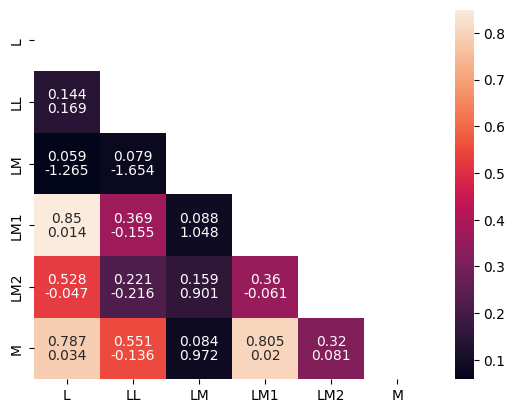

In [129]:
mask = np.triu(np.ones_like(pvalues), k=1).astype(bool)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask, annot=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(mat.mean(axis=0).data, 3), annot_kws={'va':'top'}, fmt="", cbar=False)
sns.heatmap(pvalues, xticklabels=labels, yticklabels=labels, mask = mask,annot=np.round(pvalues, 3), annot_kws={'va':'bottom'}, fmt="", cbar=False)
